In [1]:
import scipy
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F

# we want to use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
# import data from the moving mnist dataset
data = np.load('data/bouncing_mnist_test.npy')

# normalize the data to be between 0 and 1 (better training performance for some reason)
data = data / 255

In [3]:
class VRNN(nn.Module):

    '''
    the Varational Recurrent Neural Network VRNN is a dynamical VAE model.
    
    '''

    def __init__(self, img_size=64, hidden_size=256, latent_size=16, RNN_dim=256, CNN_channels=32):

        super(VRNN, self).__init__()

        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.rnn_dim = RNN_dim

        # convolutions parameters
        self.CNN_channels = CNN_channels
        self.img_size = img_size
        self.feature_size = (img_size-8)*(img_size-8)*CNN_channels # output of convolutional layers

        # feature extractor of observation with convolutional layers
        self.enc_conv1 = nn.Conv2d(1, CNN_channels//2, kernel_size=5)
        self.enc_conv2 = nn.Conv2d(CNN_channels//2, CNN_channels, kernel_size=5)

        # encoder part of the model
        self.encoder = nn.Sequential(
            nn.Linear(self.feature_size + RNN_dim, hidden_size),
            nn.Tanh()
        )
        self.enc_mean = nn.Linear(hidden_size, latent_size)
        self.enc_logvar = nn.Linear(hidden_size, latent_size)

        # encoding the prior on the latent space given previous dynamics
        self.prior_encoder = nn.Sequential(
            nn.Linear(RNN_dim, hidden_size),
            nn.Tanh()
        )
        self.prior_mean = nn.Linear(hidden_size, latent_size)
        self.prior_logvar = nn.Linear(hidden_size, latent_size)

        # feature extractor of latent states with inverse convolutional layers
        self.dec_conv1 = nn.ConvTranspose2d(CNN_channels, CNN_channels//2, kernel_size=5)
        self.dec_conv2 = nn.ConvTranspose2d(CNN_channels//2, 1, kernel_size=5)

        # decoder part of the model, output the reconstructed observation y_t
        self.decoder = nn.Sequential(
            nn.Linear(latent_size + RNN_dim, hidden_size),
            nn.Tanh()
        )
        self.dec_mean = nn.Linear(hidden_size, self.feature_size)
        # self.dec_logvar = nn.Linear(hidden_size, self.feature_size)

        # RNN part of the model, encode the dynamics of the latent space
        self.rnn = nn.RNN(self.feature_size + latent_size, RNN_dim)

        self.relu = nn.ReLU()

    def reparametrization(self, mean, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mean + std * eps
    
    def forward(self,x,gen_start=-1):

        seq_len, batch_size,_,_ = x.shape

        # create variable holder
        self.z_mean = torch.zeros(seq_len, batch_size, self.latent_size).to(device)
        self.z_logvar = torch.zeros(seq_len, batch_size, self.latent_size).to(device)
        self.z = torch.zeros(seq_len, batch_size, self.latent_size).to(device)

        h = torch.zeros((seq_len, batch_size, self.rnn_dim)).to(device)
        z_t = torch.zeros((batch_size, self.latent_size)).to(device)
        h_t = torch.zeros((batch_size, self.rnn_dim)).to(device) # the initial hidden state coudl be different from 0 ... (random ?)

        y = torch.zeros((seq_len, batch_size, self.img_size,self.img_size)).to(device) # observation reconstruction
        
        for t in range(seq_len):

            # here if gen_start = -1 it is a teacher-driver mode : we give the real x_t at each time step, and not the reconstructed y_t
            # else we use the reconstructed y_t as input for the next time step, starting at step gen_step,it is a sequence generation mode
            if gen_start == -1 :
                x_t = x[t,:,:,:].unsqueeze(1)
            else :
                if t < gen_start :
                    x_t = x[t,:,:,:].unsqueeze(1)
                else :
                    x_t = y[t,:,:,:].unsqueeze(1)


            # feature extractor of observation with convolutional layers
            phi_x_t = self.relu(self.enc_conv1(x_t))
            phi_x_t = self.relu(self.enc_conv2(phi_x_t))
            phi_x_t = phi_x_t.view(-1, self.feature_size)

            encoder_input = torch.cat((phi_x_t,h_t),dim=1)
            encoder_output = self.encoder(encoder_input)
            mean_zt, logvar_zt = self.enc_mean(encoder_output), self.enc_logvar(encoder_output)

            # sample the latent variable
            z_t = self.reparametrization(mean_zt, logvar_zt)

            # decode
            decoder_input = torch.cat((z_t,h_t),dim=1)
            decoder_output = self.decoder(decoder_input)
            mean_phi_z_t = self.dec_mean(decoder_output) # for now we will not sample from the decoder

            # reconstruction of the observation with convolutional layers
            y_t = self.relu(self.dec_conv1(mean_phi_z_t.view(-1, self.CNN_channels, self.img_size-8, self.img_size-8)))
            y_t = torch.sigmoid(self.dec_conv2(y_t)).squeeze(1)

            # update the hidden state
            rnn_input = torch.cat((phi_x_t,z_t),dim=1)
            h_t = self.rnn(rnn_input.unsqueeze(0),h_t.unsqueeze(0))[1].squeeze(0)

            # save variable
            y[t,:,:,:] = y_t
            self.z_mean[t,:,:] = mean_zt
            self.z_logvar[t,:,:] = logvar_zt
            self.z[t,:,:] = z_t
            h[t,:,:] = h_t

        # generation of the latent variable z prior (for the KL divergence)
        prior_encoder_output = self.prior_encoder(h)
        self.z_prior_mean = self.prior_mean(prior_encoder_output)
        self.z_prior_logvar = self.prior_logvar(prior_encoder_output)

        return y,  self.z_mean, self.z_logvar, self.z_prior_mean, self.z_prior_logvar, self.z

In [4]:
mseLoss = torch.nn.MSELoss()

def loss_function(x_reconstructed, x, mean, logvar, mean_prior=None, logvar_prior=None):
    if mean_prior is None :
        mean_prior = torch.zeros_like(mean)
    if logvar_prior is None :
        logvar_prior = torch.zeros_like(logvar)
    # reconstruction loss
    # recon_loss = mseLoss(x_reconstructed,x)
    recon_loss = F.binary_cross_entropy(x_reconstructed, x, size_average=False)
    # KL divergence
    kl_loss = -0.5 * torch.sum(logvar - logvar_prior - torch.div((logvar.exp() + (mean - mean_prior).pow(2)), logvar_prior.exp()+1e-10))
    return recon_loss + kl_loss

def count_parameters(net):
    return sum(p.numel() for p in net.parameters() if p.requires_grad)

In [5]:
img_size= 64
hidden_size = 1028
latent_size = 16
RNN_dim = 64
CNN_channels = 16

vrnn = VRNN(img_size=img_size, hidden_size= hidden_size, latent_size= latent_size, 
            RNN_dim=RNN_dim,CNN_channels=CNN_channels)
vrnn = vrnn.to(device)
opt = torch.optim.Adam(vrnn.parameters(),lr = 1e-3)
count_parameters(vrnn)

106718141

In [6]:
batch_size= 64

train_loader = torch.utils.data.DataLoader(
                 dataset=data,
                 batch_size=batch_size,
                 shuffle=True)

def train(nb_epochs=1,batch_size=128):
    for epoch in range(nb_epochs):
        pbar = tqdm(train_loader)
        pbar.set_description("epoch %s/ loss=? " % str(epoch+1))
        for x in pbar:
            x = torch.reshape(x,(20,-1,64,64)).float().to(device)
            opt.zero_grad()
            y, mean, logvar, mean_prior, logvar_prior, z = vrnn.forward(x)
            loss = loss_function(y,x,mean,logvar,mean_prior,logvar_prior)
            loss.backward()
            opt.step()
            pbar.set_description("epoch "+str(epoch+1)+"/"+str(nb_epochs)+"/ loss= "+str(loss.cpu().detach().numpy()) )

In [8]:
train(nb_epochs=10,batch_size=batch_size)

epoch 1/ loss=? :   0%|          | 0/157 [00:00<?, ?it/s]c:\Users\fphub\mambaforge\envs\iblenv\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
epoch 10/10/ loss= 112804.125: 100%|██████████| 157/157 [15:44<00:00,  6.02s/it]


In [12]:
torch.save(vrnn.state_dict(), 'model/vrnn_moving_digits_big.pt')

In [8]:
vrnn = VRNN(img_size=img_size, hidden_size= hidden_size, latent_size= latent_size, 
            RNN_dim=RNN_dim,CNN_channels=CNN_channels).to(device)
vrnn.load_state_dict(torch.load('model/vrnn_moving_digits_big.pt'))
vrnn.eval()

VRNN(
  (enc_conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (enc_conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (encoder): Sequential(
    (0): Linear(in_features=50240, out_features=1028, bias=True)
    (1): Tanh()
  )
  (enc_mean): Linear(in_features=1028, out_features=16, bias=True)
  (enc_logvar): Linear(in_features=1028, out_features=16, bias=True)
  (prior_encoder): Sequential(
    (0): Linear(in_features=64, out_features=1028, bias=True)
    (1): Tanh()
  )
  (prior_mean): Linear(in_features=1028, out_features=16, bias=True)
  (prior_logvar): Linear(in_features=1028, out_features=16, bias=True)
  (dec_conv1): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(1, 1))
  (dec_conv2): ConvTranspose2d(8, 1, kernel_size=(5, 5), stride=(1, 1))
  (decoder): Sequential(
    (0): Linear(in_features=80, out_features=1028, bias=True)
    (1): Tanh()
  )
  (dec_mean): Linear(in_features=1028, out_features=50176, bias=True)
  (rnn): RNN(50192, 64)
  (relu): ReLU()
)

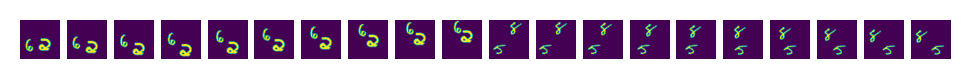

In [56]:
# test the reconstruction
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200


def plot_video(video):
    fig,ax = plt.subplots(1,20)
    for i in range(20):
        ax[i].imshow(video[i,:,:])
        ax[i].axis('off')

random_index = np.random.randint(1000)
sample = data[random_index]
sample = np.concatenate((data[random_index][:10],data[random_index+1][:10]))
plot_video(sample)

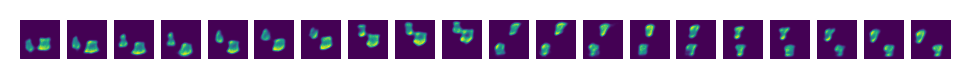

In [61]:
sample_tensor = torch.reshape(torch.tensor(sample).float(),(20,1,64,64)).float().to(device)
y, mean, logvar, mean_prior, logvar_prior, z = vrnn.forward(sample_tensor)
reconstructed_sample = y.cpu().detach().numpy().reshape((20,64,64))

plot_video(reconstructed_sample)

In [62]:
var_posterior = np.exp(np.mean(logvar.cpu().detach().numpy().reshape((20,16)),axis=1))
var_prior = np.exp(np.mean(logvar_prior.cpu().detach().numpy().reshape((20,16)),axis=1))

pred_distance = np.linalg.norm(z.cpu().detach().numpy().reshape((20,16))-mean.cpu().detach().numpy().reshape((20,16)),axis=1)

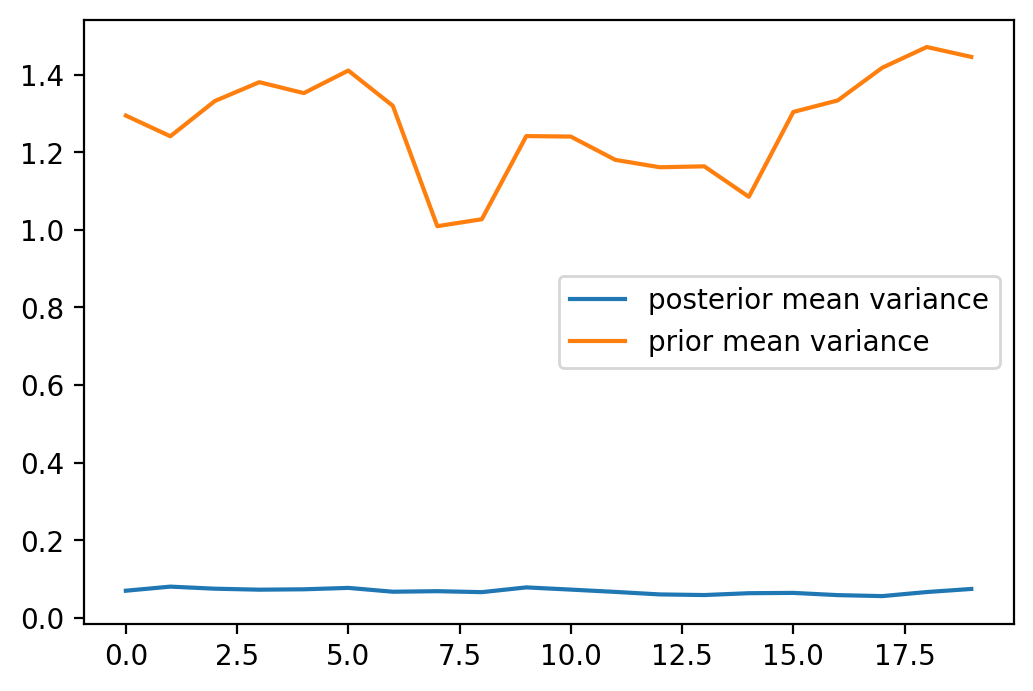

In [64]:
plt.figure()
plt.plot(var_posterior,label='posterior mean variance')
plt.plot(var_prior,label='prior mean variance')
#plt.plot(pred_distance,label='prediction distance')
plt.legend()
plt.show()

In [ ]:
for name, param in vrnn.named_parameters():
    if param.requires_grad:
        print(name)